In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [2]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/Stuart_GSE128639/Stuart_bm_v2.h5ad')
data.shape

(30011, 17009)

In [3]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [4]:
# data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l2'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['CD14_Mono', 'CD16_Mono', 'CD4_Memory', 'CD4_Naive', 'CD56_bright_NK', 'CD8_Effector_1', 'CD8_Effector_2', 'CD8_Memory_1', 'CD8_Memory_2', 'CD8_Naive', 'GMP', 'HSC', 'LMPP', 'MAIT', 'Memory_B', 'NK', 'Naive_B', 'Plasmablast', 'Prog_B_1', 'Prog_B_2', 'Prog_DC', 'Prog_Mk', 'Prog_RBC', 'Treg', 'cDC2', 'gdT', 'pDC']


## Cell count for each type

In [5]:
data.obs['celltype.l2'].value_counts()

CD14_Mono         6435
CD4_Naive         4370
CD8_Naive         3835
CD4_Memory        3329
Naive_B           1892
Memory_B          1620
NK                1251
Prog_RBC           745
GMP                739
CD8_Effector_1     571
CD8_Memory_2       549
MAIT               514
cDC2               474
CD8_Memory_1       438
CD16_Mono          427
gdT                366
pDC                322
CD8_Effector_2     303
Treg               291
LMPP               287
Prog_DC            260
HSC                258
Plasmablast        221
Prog_B_1           142
Prog_B_2           126
CD56_bright_NK     125
Prog_Mk            121
Name: celltype.l2, dtype: int64

## Read features

In [6]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level2_onlylog1p/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [7]:
features_dict['CD14_Mono'].head()

,Gene,Weight,Tendency
0,CTSS,0.445518,1
1,S100A9,0.280234,1
2,S100A8,0.260274,1
3,PTMA,-0.557675,0
4,RPS20,-0.001441,0


In [8]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
CD14_Mono,19,9
CD16_Mono,23,7
CD4_Memory,112,57
CD4_Naive,95,48
CD56_bright_NK,8,0
CD8_Effector_1,14,3
CD8_Effector_2,24,6
CD8_Memory_1,8,1
CD8_Memory_2,10,2
CD8_Naive,170,75


## Get likelihood from LR model

In [28]:
def LR_likelihood(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    decision_scores = clf.decision_function(X)  # >0: predict celltype, <0: predict not celltype
    print('decision_scores > 0:', sum(decision_scores > 0))  # decision_scores > 0 的有幾個

    ### calculate the likelihood of the positive class for each observation in X based on the decision scores
    likelihood = 1 / (1 + np.exp(-decision_scores))
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # >0.5: predict celltype, <0.5: predict not celltype
    print(type(likelihood), likelihood.shape)
    #do the row-wise softmax
    # likelihood = np.exp(likelihood)/np.sum(np.exp(likelihood),1,keepdims=True)
    
    # likelihood is a 1-D array with the same length as the number of cells
    return likelihood


In [ ]:
celltype = 'B_cell'  # original 3733 B cells
B_likelihood = LR_likelihood(data, features_dict, celltype)
B_likelihood.shape

In [29]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = LR_likelihood(data, features_dict, celltype)

Celltype: CD14_Mono
decision_scores > 0: 6612
likelihood > 0.5: 6612
<class 'numpy.ndarray'> (30011,)
Celltype: CD16_Mono
decision_scores > 0: 424
likelihood > 0.5: 424
<class 'numpy.ndarray'> (30011,)
Celltype: CD4_Memory
decision_scores > 0: 2945
likelihood > 0.5: 2945
<class 'numpy.ndarray'> (30011,)
Celltype: CD4_Naive
decision_scores > 0: 3829
likelihood > 0.5: 3829
<class 'numpy.ndarray'> (30011,)
Celltype: CD56_bright_NK
decision_scores > 0: 0
likelihood > 0.5: 0
<class 'numpy.ndarray'> (30011,)
Celltype: CD8_Effector_1
decision_scores > 0: 24
likelihood > 0.5: 24
<class 'numpy.ndarray'> (30011,)
Celltype: CD8_Effector_2
decision_scores > 0: 150
likelihood > 0.5: 150
<class 'numpy.ndarray'> (30011,)
Celltype: CD8_Memory_1
decision_scores > 0: 3
likelihood > 0.5: 3
<class 'numpy.ndarray'> (30011,)
Celltype: CD8_Memory_2
decision_scores > 0: 12
likelihood > 0.5: 12
<class 'numpy.ndarray'> (30011,)
Celltype: CD8_Naive


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


decision_scores > 0: 3592
likelihood > 0.5: 3592
<class 'numpy.ndarray'> (30011,)
Celltype: GMP
decision_scores > 0: 674
likelihood > 0.5: 674
<class 'numpy.ndarray'> (30011,)
Celltype: HSC
decision_scores > 0: 230
likelihood > 0.5: 230
<class 'numpy.ndarray'> (30011,)
Celltype: LMPP
decision_scores > 0: 258
likelihood > 0.5: 258
<class 'numpy.ndarray'> (30011,)
Celltype: MAIT
decision_scores > 0: 328
likelihood > 0.5: 328
<class 'numpy.ndarray'> (30011,)
Celltype: Memory_B
decision_scores > 0: 1297
likelihood > 0.5: 1297
<class 'numpy.ndarray'> (30011,)
Celltype: NK
decision_scores > 0: 1257
likelihood > 0.5: 1257
<class 'numpy.ndarray'> (30011,)
Celltype: Naive_B
decision_scores > 0: 1798
likelihood > 0.5: 1798
<class 'numpy.ndarray'> (30011,)
Celltype: Plasmablast
decision_scores > 0: 212
likelihood > 0.5: 212
<class 'numpy.ndarray'> (30011,)
Celltype: Prog_B_1
decision_scores > 0: 6
likelihood > 0.5: 6
<class 'numpy.ndarray'> (30011,)
Celltype: Prog_B_2
decision_scores > 0: 117
lik

In [30]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
print(likelihood_df.shape)
likelihood_df.head()

(30011, 27)


,CD14_Mono,CD16_Mono,CD4_Memory,CD4_Naive,CD56_bright_NK,CD8_Effector_1,CD8_Effector_2,CD8_Memory_1,CD8_Memory_2,CD8_Naive,...,Plasmablast,Prog_B_1,Prog_B_2,Prog_DC,Prog_Mk,Prog_RBC,Treg,cDC2,gdT,pDC
0,3.998881e-09,3.032879e-06,0.000187,0.000322,0.002210,0.000072,0.000001,0.001594,0.000290,0.000216,...,7.145692e-05,0.002380,9.758371e-06,6.349221e-03,7.324324e-02,0.152609,0.000577,2.305071e-07,0.000052,2.211459e-07
1,1.412024e-06,2.941248e-14,0.101886,0.014598,0.005500,0.007917,0.000911,0.063488,0.018563,0.018840,...,5.797736e-07,0.002864,3.379150e-07,1.168778e-13,5.871686e-08,0.000015,0.011313,2.727180e-10,0.019978,1.811367e-11
2,1.661754e-14,1.041912e-11,0.016302,0.442006,0.005058,0.002529,0.001007,0.001834,0.000535,0.391955,...,1.231266e-08,0.004884,3.543013e-10,3.418073e-15,1.965354e-06,0.000045,0.016207,1.311429e-14,0.000017,8.128787e-12
3,2.376804e-07,1.116708e-10,0.148540,0.068966,0.004341,0.013632,0.004796,0.082264,0.033486,0.001594,...,2.982502e-07,0.002942,2.073628e-08,1.644135e-11,8.842150e-07,0.000634,0.018205,1.382426e-11,0.008372,4.462486e-07
4,9.915746e-01,4.271339e-05,0.000268,0.000040,0.003364,0.000177,0.000002,0.000897,0.000269,0.000004,...,1.052122e-04,0.003261,1.653600e-08,1.589238e-08,1.028797e-03,0.000864,0.001731,1.830985e-03,0.000005,1.124100e-06


In [31]:
# row sum
likelihood_df.sum(axis=1)


0        0.252056
1        0.301621
2        0.883745
3        0.388643
4        1.015673
           ...   
30006    0.940975
30007    0.463634
30008    0.841491
30009    1.113446
30010    1.080819
Length: 30011, dtype: float64

In [ ]:
# os.chdir('/Users/evanli/Documents/EvanPys/Progress/Stuart_bm/Level1_onlylog1p/LR_likelihood')
# likelihood_df.to_csv('L1_likelihood_df.csv')

### 20231227: add softmax operation to likelihood, poor result

In [ ]:
# Applying row-wise softmax
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=1, keepdims=True)

likelihood_softmax = pd.DataFrame(softmax(likelihood_df.values), columns=likelihood_df.columns)
likelihood_softmax.shape

## Odds ratio: (1st_type / 2nd_type) >= 1.5

In [32]:
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

# for index, row in likelihood_softmax.iterrows():
for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


(30011, 6)

In [33]:
result_df.head(20)

,Largest Value,Largest Column,Second Largest Value,Second Largest Column,Odds Ratio,Assignment
0,0.152609,Prog_RBC,0.073243,Prog_Mk,2.083593,Prog_RBC
1,0.101886,CD4_Memory,0.063488,CD8_Memory_1,1.604808,CD4_Memory
2,0.442006,CD4_Naive,0.391955,CD8_Naive,1.127696,Uncertain
3,0.148540,CD4_Memory,0.082264,CD8_Memory_1,1.805662,CD4_Memory
4,0.991575,CD14_Mono,0.008034,Memory_B,123.416111,CD14_Mono
5,0.992130,Naive_B,0.288895,Memory_B,3.434222,Naive_B
6,0.999019,CD8_Naive,0.479781,CD4_Naive,2.082241,CD8_Naive
7,0.989516,CD14_Mono,0.014909,GMP,66.371411,CD14_Mono
8,0.677607,Naive_B,0.227462,Memory_B,2.978988,Naive_B
9,0.773888,CD8_Naive,0.666183,CD4_Naive,1.161675,Uncertain


In [34]:
sum(result_df['Assignment'] == 'Uncertain')

3456

## Confusion heatmap

In [36]:
import pandas as pd

# Get the true labels
true_labels = data.obs['celltype.l2'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [37]:
cm.shape

(27, 28)

In [38]:
cm

Predicted,CD14_Mono,CD16_Mono,CD4_Memory,CD4_Naive,CD56_bright_NK,CD8_Effector_1,CD8_Effector_2,CD8_Memory_1,CD8_Memory_2,CD8_Naive,...,Prog_B_1,Prog_B_2,Prog_DC,Prog_Mk,Prog_RBC,Treg,cDC2,gdT,pDC,Uncertain
True,,,,,,,,,,,,,,,,,,,,,
CD14_Mono,6322,10,1,2,0,0,0,0,0,1,...,0,0,0,0,1,0,7,0,0,65
CD16_Mono,16,376,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,35
CD4_Memory,2,0,2773,206,0,2,0,16,0,16,...,1,0,0,0,0,1,0,2,0,290
CD4_Naive,1,0,176,3646,2,0,0,0,0,119,...,1,0,0,0,0,1,0,0,0,423
CD56_bright_NK,1,0,19,0,0,0,1,0,2,5,...,0,0,0,0,0,0,0,2,0,27
CD8_Effector_1,0,0,23,10,0,157,21,1,34,23,...,0,0,0,0,0,0,0,8,0,264
CD8_Effector_2,2,0,6,2,0,31,123,1,9,8,...,0,0,0,0,0,1,0,0,0,117
CD8_Memory_1,0,0,102,16,0,26,3,28,8,106,...,0,0,0,0,0,0,0,2,0,145
CD8_Memory_2,1,0,47,2,0,72,23,2,58,13,...,0,0,1,0,0,0,0,2,0,277


In [ ]:
# export confusion matrix
# cm.to_csv('L1_OR_confusion_matrix.csv')

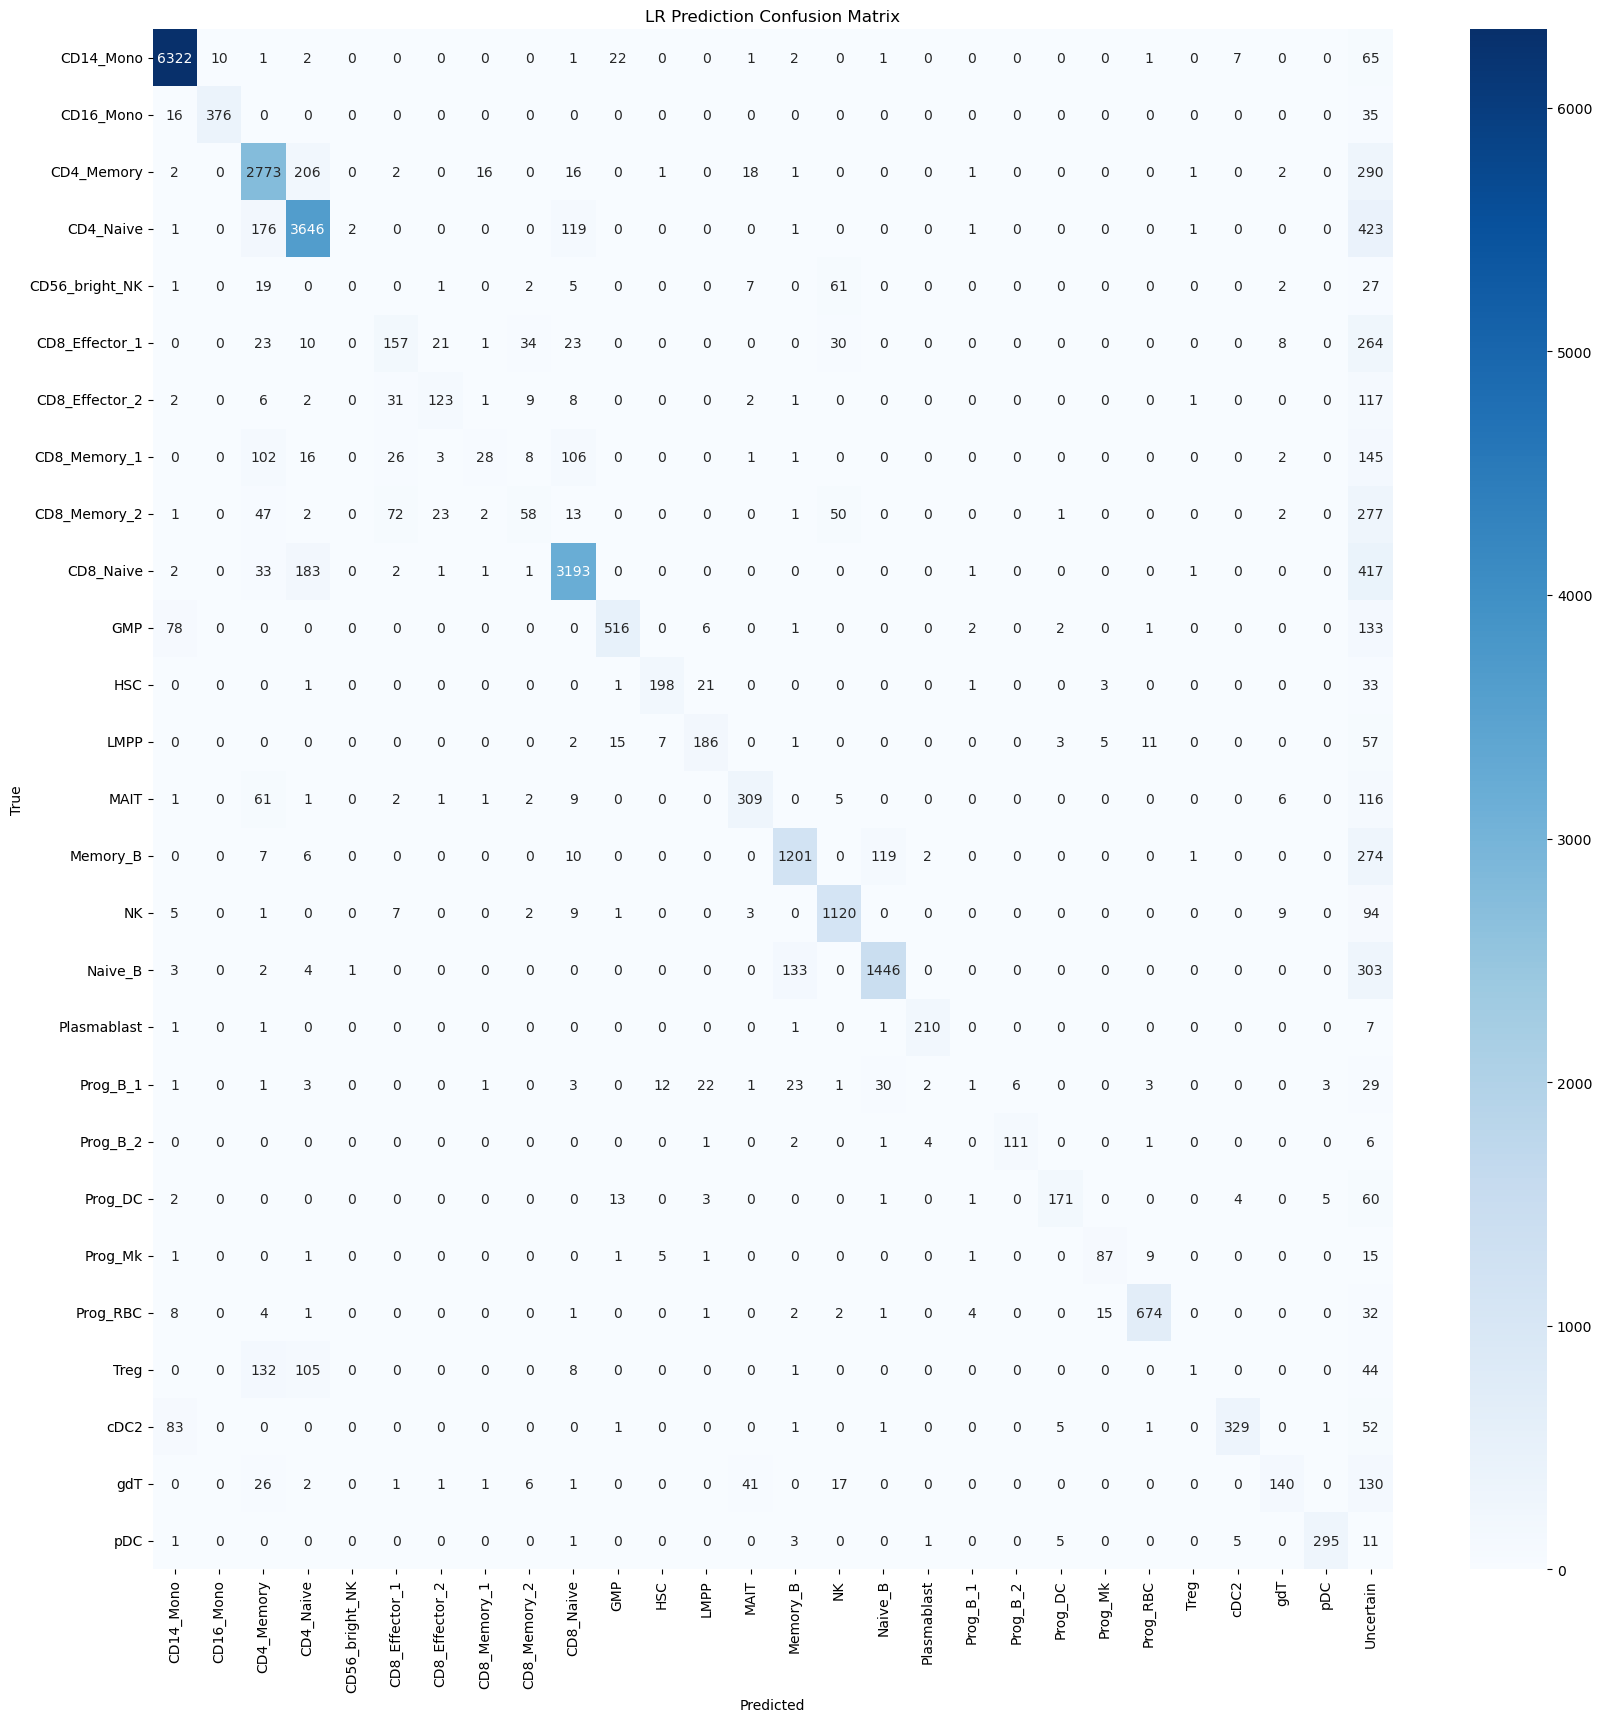

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Prediction Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [40]:
row_sum = cm.sum(axis=1)
row_sum


True
CD14_Mono         6435
CD16_Mono          427
CD4_Memory        3329
CD4_Naive         4370
CD56_bright_NK     125
CD8_Effector_1     571
CD8_Effector_2     303
CD8_Memory_1       438
CD8_Memory_2       549
CD8_Naive         3835
GMP                739
HSC                258
LMPP               287
MAIT               514
Memory_B          1620
NK                1251
Naive_B           1892
Plasmablast        221
Prog_B_1           142
Prog_B_2           126
Prog_DC            260
Prog_Mk            121
Prog_RBC           745
Treg               291
cDC2               474
gdT                366
pDC                322
dtype: int64

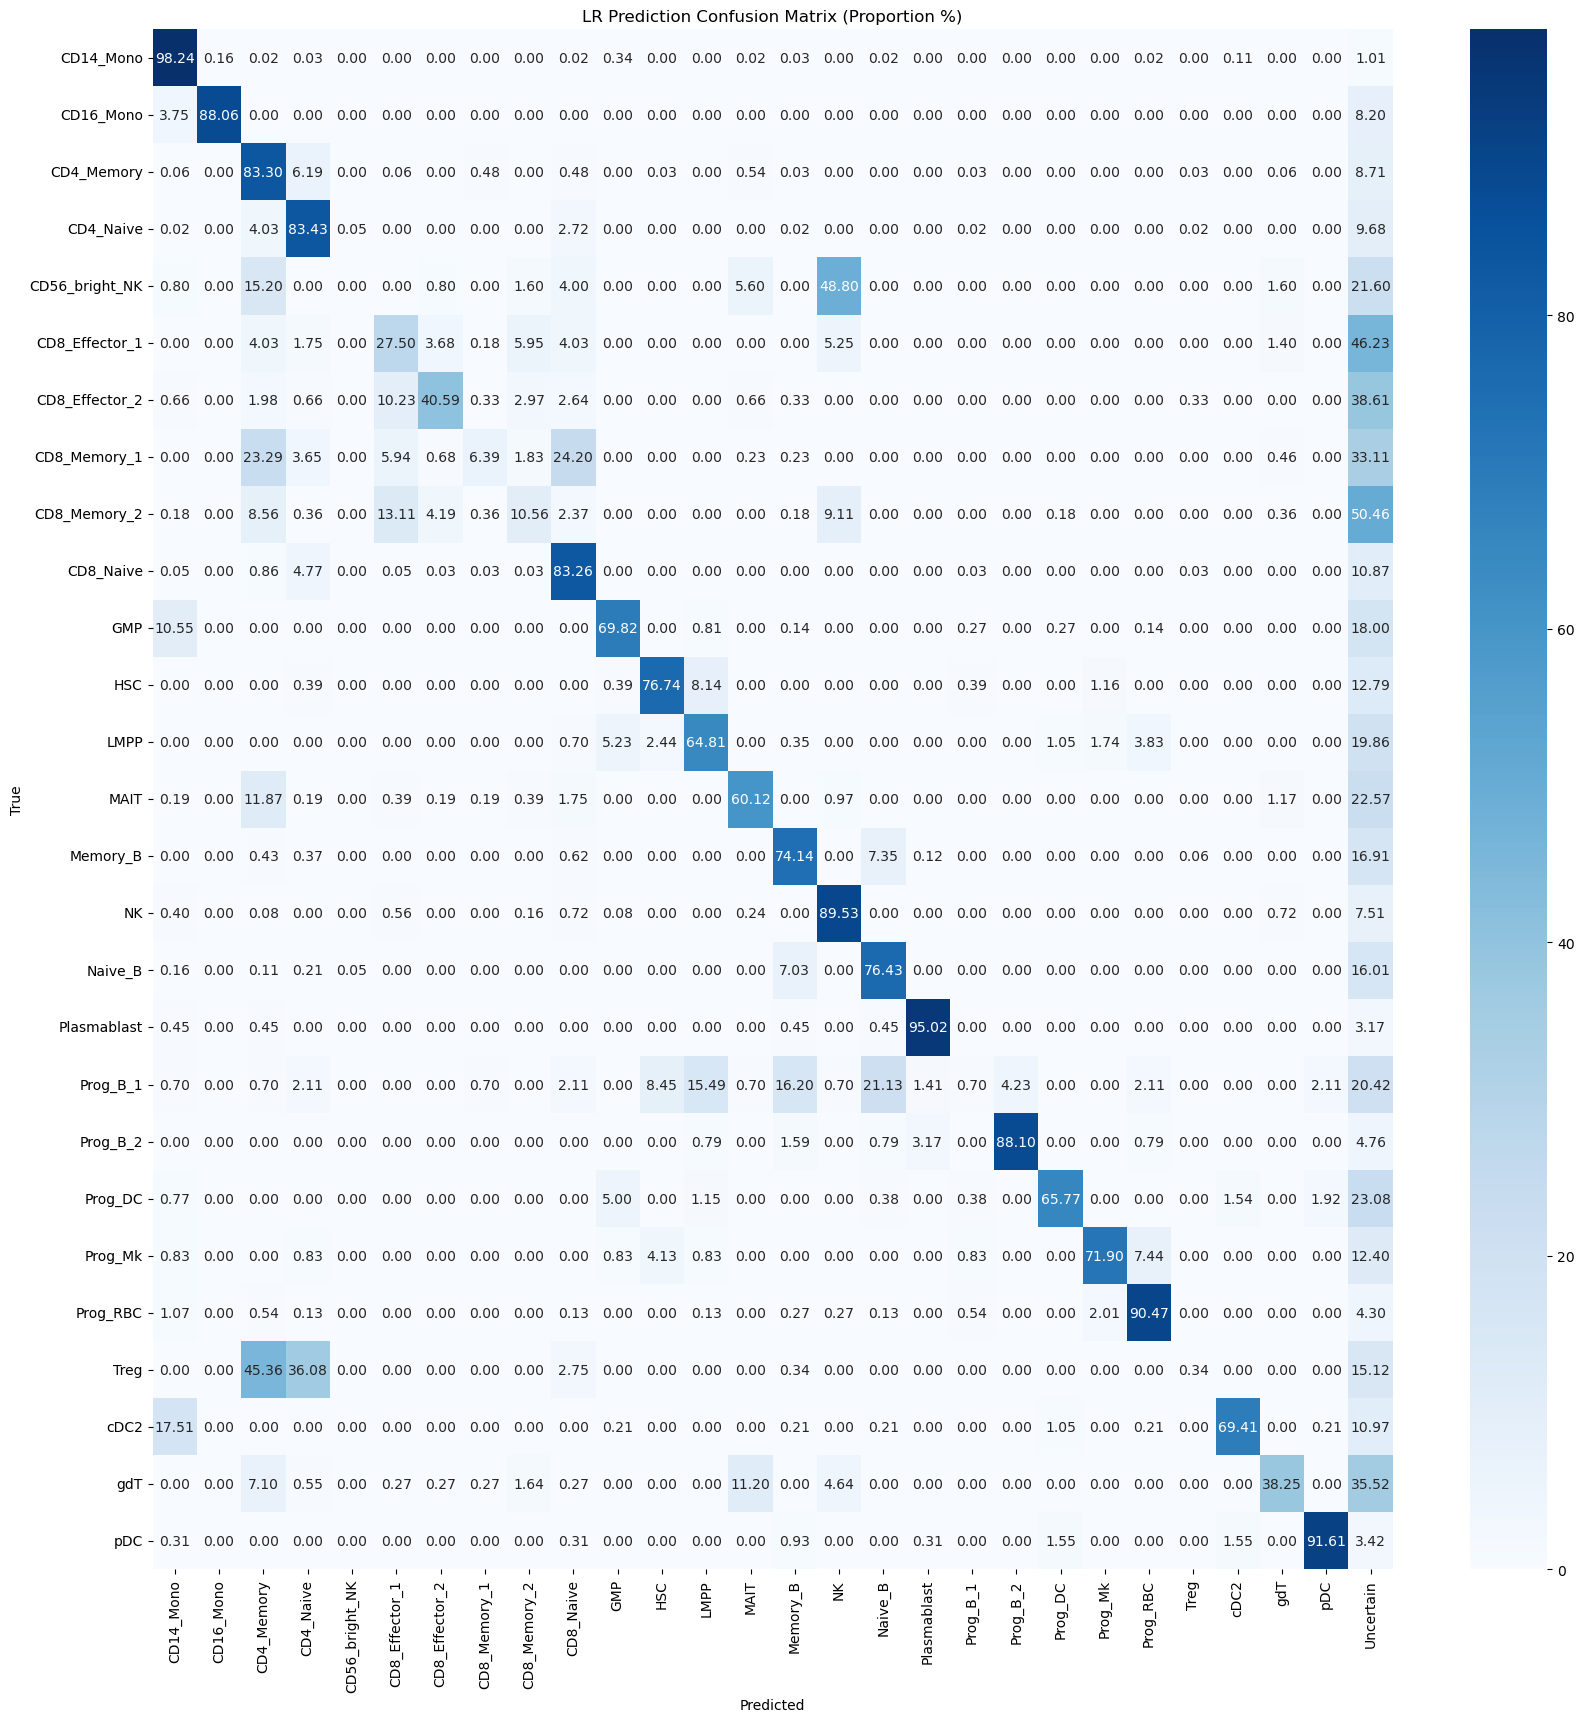

In [44]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(20, 20))
sns.heatmap(cm_proportion, fmt=".2f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()

## Calculate accuracy

In [42]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.788744127153377

In [43]:
cm.values.sum()

30011

## Use predict_proba to calculate likelihood

In [11]:
def new_LR_likelihood(data, all_features_dict, celltype):
    print('====================')
    print('Celltype:', celltype)
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l2'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # likelihood of the positive class for each observation
    likelihood = clf.predict_proba(X)[:, 1]  # >0.5: predict celltype, <0.5: predict not celltype
    print('likelihood > 0.5:', sum(likelihood > 0.5))  # decision_scores > 0 的有幾個

    return likelihood


In [ ]:
celltype = 'B_cell'
likelihood = new_LR_likelihood(data, features_dict, celltype)

In [ ]:
sum(likelihood >= 0.5)

In [12]:
likelihood_dict = {}
for celltype in types:
    likelihood_dict[celltype] = new_LR_likelihood(data, features_dict, celltype)

Celltype: CD14_Mono
likelihood > 0.5: 6612
Celltype: CD16_Mono
likelihood > 0.5: 424
Celltype: CD4_Memory
likelihood > 0.5: 2945
Celltype: CD4_Naive
likelihood > 0.5: 3829
Celltype: CD56_bright_NK
likelihood > 0.5: 0
Celltype: CD8_Effector_1
likelihood > 0.5: 24
Celltype: CD8_Effector_2
likelihood > 0.5: 150
Celltype: CD8_Memory_1
likelihood > 0.5: 3
Celltype: CD8_Memory_2
likelihood > 0.5: 12
Celltype: CD8_Naive


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


likelihood > 0.5: 3592
Celltype: GMP
likelihood > 0.5: 674
Celltype: HSC
likelihood > 0.5: 230
Celltype: LMPP
likelihood > 0.5: 258
Celltype: MAIT
likelihood > 0.5: 328
Celltype: Memory_B
likelihood > 0.5: 1297
Celltype: NK
likelihood > 0.5: 1257
Celltype: Naive_B
likelihood > 0.5: 1798
Celltype: Plasmablast
likelihood > 0.5: 212
Celltype: Prog_B_1
likelihood > 0.5: 6
Celltype: Prog_B_2
likelihood > 0.5: 117
Celltype: Prog_DC
likelihood > 0.5: 237
Celltype: Prog_Mk
likelihood > 0.5: 86
Celltype: Prog_RBC
likelihood > 0.5: 655
Celltype: Treg
likelihood > 0.5: 3
Celltype: cDC2
likelihood > 0.5: 394
Celltype: gdT
likelihood > 0.5: 232
Celltype: pDC
likelihood > 0.5: 309


In [13]:
# turn likelihood_dict into dataframe
likelihood_df = pd.DataFrame(likelihood_dict)
print(likelihood_df.shape)
likelihood_df.head()

(30011, 27)


,CD14_Mono,CD16_Mono,CD4_Memory,CD4_Naive,CD56_bright_NK,CD8_Effector_1,CD8_Effector_2,CD8_Memory_1,CD8_Memory_2,CD8_Naive,...,Plasmablast,Prog_B_1,Prog_B_2,Prog_DC,Prog_Mk,Prog_RBC,Treg,cDC2,gdT,pDC
0,3.998881e-09,3.032879e-06,0.000187,0.000322,0.002210,0.000072,0.000001,0.001594,0.000290,0.000216,...,7.145692e-05,0.002380,9.758371e-06,6.349221e-03,7.324324e-02,0.152609,0.000577,2.305071e-07,0.000052,2.211459e-07
1,1.412024e-06,2.941248e-14,0.101886,0.014598,0.005500,0.007917,0.000911,0.063488,0.018563,0.018840,...,5.797736e-07,0.002864,3.379150e-07,1.168778e-13,5.871686e-08,0.000015,0.011313,2.727180e-10,0.019978,1.811367e-11
2,1.661754e-14,1.041912e-11,0.016302,0.442006,0.005058,0.002529,0.001007,0.001834,0.000535,0.391955,...,1.231266e-08,0.004884,3.543013e-10,3.418073e-15,1.965354e-06,0.000045,0.016207,1.311429e-14,0.000017,8.128787e-12
3,2.376804e-07,1.116708e-10,0.148540,0.068966,0.004341,0.013632,0.004796,0.082264,0.033486,0.001594,...,2.982502e-07,0.002942,2.073628e-08,1.644135e-11,8.842150e-07,0.000634,0.018205,1.382426e-11,0.008372,4.462486e-07
4,9.915746e-01,4.271339e-05,0.000268,0.000040,0.003364,0.000177,0.000002,0.000897,0.000269,0.000004,...,1.052122e-04,0.003261,1.653600e-08,1.589238e-08,1.028797e-03,0.000864,0.001731,1.830985e-03,0.000005,1.124100e-06


In [14]:
# row sum
likelihood_df.sum(axis=1)


0        0.252056
1        0.301621
2        0.883745
3        0.388643
4        1.015673
           ...   
30006    0.940975
30007    0.463634
30008    0.841491
30009    1.113446
30010    1.080819
Length: 30011, dtype: float64

In [15]:
largest_values = []
second_largest_values = []
largest_columns = []
second_largest_columns = []
odds_ratio_list = []
assignments = []

# for index, row in likelihood_softmax.iterrows():
for index, row in likelihood_df.iterrows():
    # find 1st and 2nd largest values and their corresponding columns
    largest_value = row.max()
    largest_column = row.idxmax()
    second_largest_value = row.nlargest(2).iloc[-1]
    second_largest_column = row.nlargest(2).index[-1]
    
    largest_values.append(largest_value)
    second_largest_values.append(second_largest_value)
    largest_columns.append(largest_column)
    second_largest_columns.append(second_largest_column)

    # calculate odds ratio
    odds_ratio = largest_value / second_largest_value
    if odds_ratio >= 1.5:
        assign = largest_column
    else:
        assign = 'Uncertain'
    odds_ratio_list.append(odds_ratio)
    assignments.append(assign)

result_df = pd.DataFrame({'Largest Value': largest_values, 'Largest Column': largest_columns,
                          'Second Largest Value': second_largest_values, 'Second Largest Column': second_largest_columns, 
                          'Odds Ratio': odds_ratio_list, 'Assignment': assignments})
result_df.shape


(30011, 6)

In [16]:
result_df.head(20)

,Largest Value,Largest Column,Second Largest Value,Second Largest Column,Odds Ratio,Assignment
0,0.152609,Prog_RBC,0.073243,Prog_Mk,2.083593,Prog_RBC
1,0.101886,CD4_Memory,0.063488,CD8_Memory_1,1.604808,CD4_Memory
2,0.442006,CD4_Naive,0.391955,CD8_Naive,1.127696,Uncertain
3,0.148540,CD4_Memory,0.082264,CD8_Memory_1,1.805662,CD4_Memory
4,0.991575,CD14_Mono,0.008034,Memory_B,123.416111,CD14_Mono
5,0.992130,Naive_B,0.288895,Memory_B,3.434222,Naive_B
6,0.999019,CD8_Naive,0.479781,CD4_Naive,2.082241,CD8_Naive
7,0.989516,CD14_Mono,0.014909,GMP,66.371411,CD14_Mono
8,0.677607,Naive_B,0.227462,Memory_B,2.978988,Naive_B
9,0.773888,CD8_Naive,0.666183,CD4_Naive,1.161675,Uncertain


In [17]:
sum(result_df['Assignment'] == 'Uncertain')

3456

In [18]:
3456/len(result_df)

0.11515777548232314

In [19]:
import pandas as pd

# Get the true labels
true_labels = data.obs['celltype.l2'].tolist()

# Get the predicted labels
predicted_labels = result_df['Assignment'].tolist()

# Create the confusion matrix
cm = pd.crosstab(true_labels, predicted_labels, rownames=['True'], colnames=['Predicted'], margins=False)

# reorder columns
cm = cm.reindex(types + ['Uncertain'], axis=1)

# replace NaN with 0
cm = cm.fillna(0)
cm = cm.astype(int)


In [20]:
cm

Predicted,CD14_Mono,CD16_Mono,CD4_Memory,CD4_Naive,CD56_bright_NK,CD8_Effector_1,CD8_Effector_2,CD8_Memory_1,CD8_Memory_2,CD8_Naive,...,Prog_B_1,Prog_B_2,Prog_DC,Prog_Mk,Prog_RBC,Treg,cDC2,gdT,pDC,Uncertain
True,,,,,,,,,,,,,,,,,,,,,
CD14_Mono,6322,10,1,2,0,0,0,0,0,1,...,0,0,0,0,1,0,7,0,0,65
CD16_Mono,16,376,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,35
CD4_Memory,2,0,2773,206,0,2,0,16,0,16,...,1,0,0,0,0,1,0,2,0,290
CD4_Naive,1,0,176,3646,2,0,0,0,0,119,...,1,0,0,0,0,1,0,0,0,423
CD56_bright_NK,1,0,19,0,0,0,1,0,2,5,...,0,0,0,0,0,0,0,2,0,27
CD8_Effector_1,0,0,23,10,0,157,21,1,34,23,...,0,0,0,0,0,0,0,8,0,264
CD8_Effector_2,2,0,6,2,0,31,123,1,9,8,...,0,0,0,0,0,1,0,0,0,117
CD8_Memory_1,0,0,102,16,0,26,3,28,8,106,...,0,0,0,0,0,0,0,2,0,145
CD8_Memory_2,1,0,47,2,0,72,23,2,58,13,...,0,0,1,0,0,0,0,2,0,277


In [21]:
row_sum = cm.sum(axis=1)
row_sum


True
CD14_Mono         6435
CD16_Mono          427
CD4_Memory        3329
CD4_Naive         4370
CD56_bright_NK     125
CD8_Effector_1     571
CD8_Effector_2     303
CD8_Memory_1       438
CD8_Memory_2       549
CD8_Naive         3835
GMP                739
HSC                258
LMPP               287
MAIT               514
Memory_B          1620
NK                1251
Naive_B           1892
Plasmablast        221
Prog_B_1           142
Prog_B_2           126
Prog_DC            260
Prog_Mk            121
Prog_RBC           745
Treg               291
cDC2               474
gdT                366
pDC                322
dtype: int64

In [23]:
import seaborn as sns

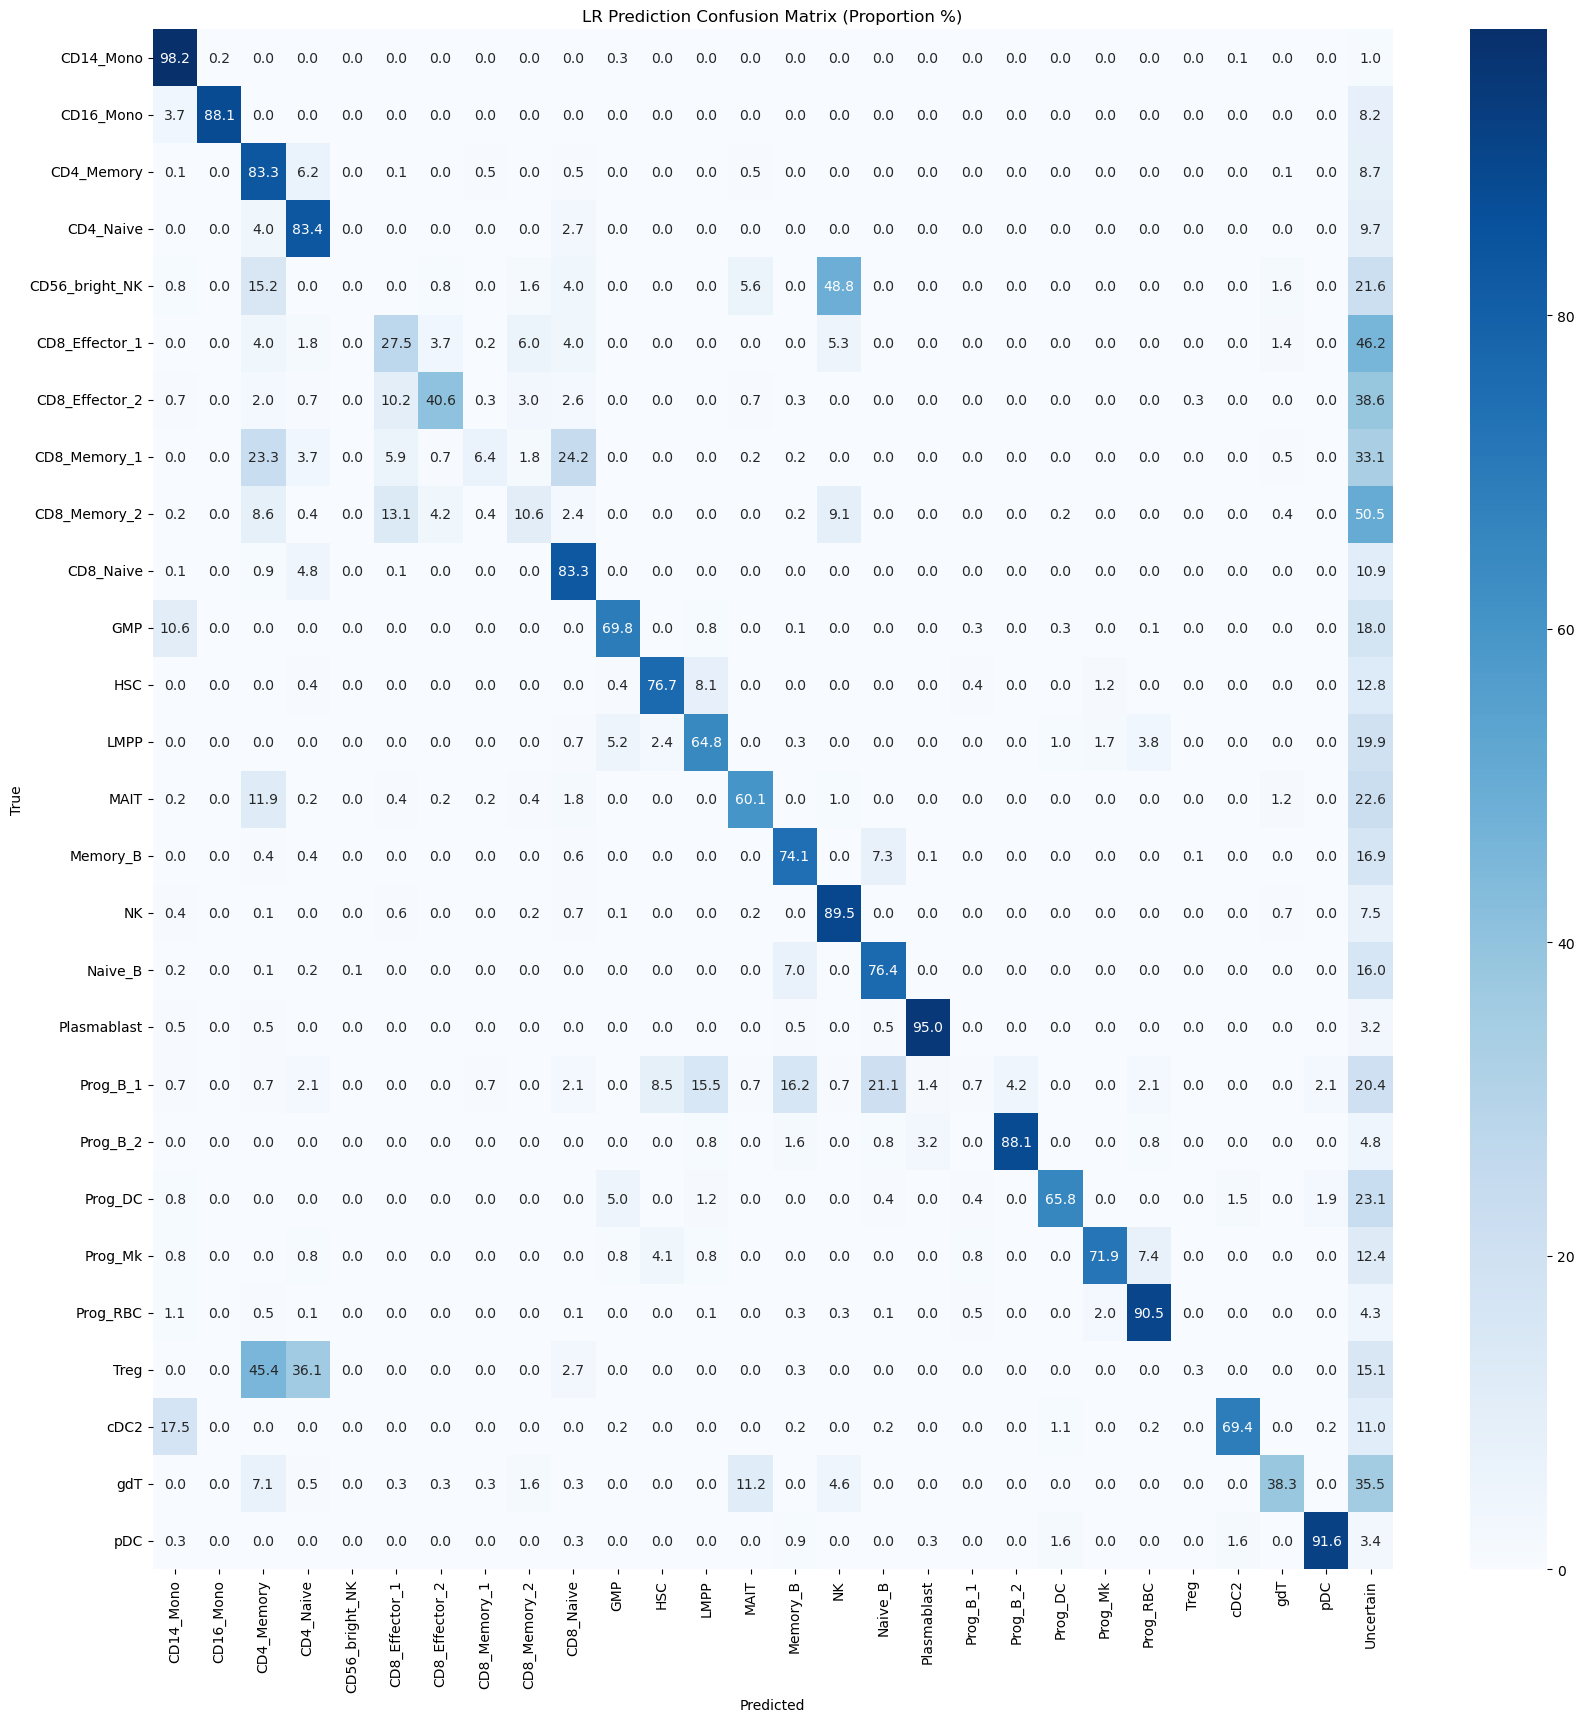

In [25]:
cm_proportion = cm.div(row_sum, axis=0)
cm_proportion *= 100
plt.figure(figsize=(20, 20))
sns.heatmap(cm_proportion, fmt=".1f", annot=True, cmap='Blues')
plt.title('LR Prediction Confusion Matrix (Proportion %)')
plt.show()

## Calculate accuracy

In [26]:
accuracy = sum(np.diag(cm)) / cm.values.sum()
accuracy

0.788744127153377

In [27]:
cm.values.sum()

30011